# **TP3 - Exercicio 1 - Grupo 11**

Bruno Miguel Fernandes Araújo - A97509

Tiago Emanuel Lemos Teixeira - A97666


Faça 

1. Defina um autómato híbrido que descreva a dinâmica do sistema segundo as notas abaixo indicadas e com os “switchs” por si escolhidos.
2. A condição de segurança estabelece que o sistema não permaneça no modo `free`  ou no modo `blocked` mais do que $\,\tau\,$ segundos.
3. Defina um SFOTS que modele a discretização do autómato híbrido.
4. Verifique nesse modelo
    1. Que as condições de segurança são invariantes do sistema
    2. Que o sistema atinge o estado `stopped` eventualmente.

1. Durante  a travagem não existe qualquer  força no sistema excepto as forças de atrito. Quando uma superfície se desloca em relação à outra, a força de atrito  é proporcional à força de compressão entre elas.
2. No contacto rodas/solo a força de compressão é dada pelo o peso $P$ que é constante e independente do modo. Tem-se $$f = a\, P$$ sendo  $a$ a constante de atrito; o valor de $a$ depende do modo: é baixa em `Blocked` e alta nos restantes.
3. No contacto corpo/rodas,  a força de compressão é a força de travagem que aqui se assume como proporcional à diferença de velocidades<br><br>                                                                      $$F =  c\, (V-v)$$<br>      A  constante de proporcionalidade $c$ depende do modo: é elevada no modo `Stopping` e baixa nos outros.<br><br>
4. As  equações que traduzem a dinâmica  do sistema são, em todos os modo excepto `Blocked`,<br><br>                                                        $$(\dot{V} \,=\, -F)\,\land\, (\dot{v} \,=\, -a\, P  + F)$$   <br>e , no modo `Blocked`,  a dinâmica do sistema é  regida por<br>                                                         $$(V = v) \;\land\; (\,\dot{v}\,=\, -a\, P\,)$$<br><br>
5. Tanto no modo `Blocked`  como no modo `Free`  existe um “timer” que impede que o controlo aí permaneça mais do que $\,\tau\,$segundos.  Os     $$\mathsf{switch}(V,v,t,V',v',t')\,$$  nesses modos devem forçar esta condição.
6. Todos os “switchs” devem ser construídos de  modo a impedir a existência de trajetórias de Zenão.
7. No instante inicial  o modo é  `Start` e  tem-se $$\,V = v\,=\,V_0$$  . A velocidade $V_0$ é  “input” do problema.<br><br>


## Definir o autómato hibrido

Tendo em conta o desenho do automato traçado no enunciado, nós acrescentamos as circunstâncias de transição entre estados e os cálculos que serão efetuados em cada.

Obtemos então o seguinte automato.

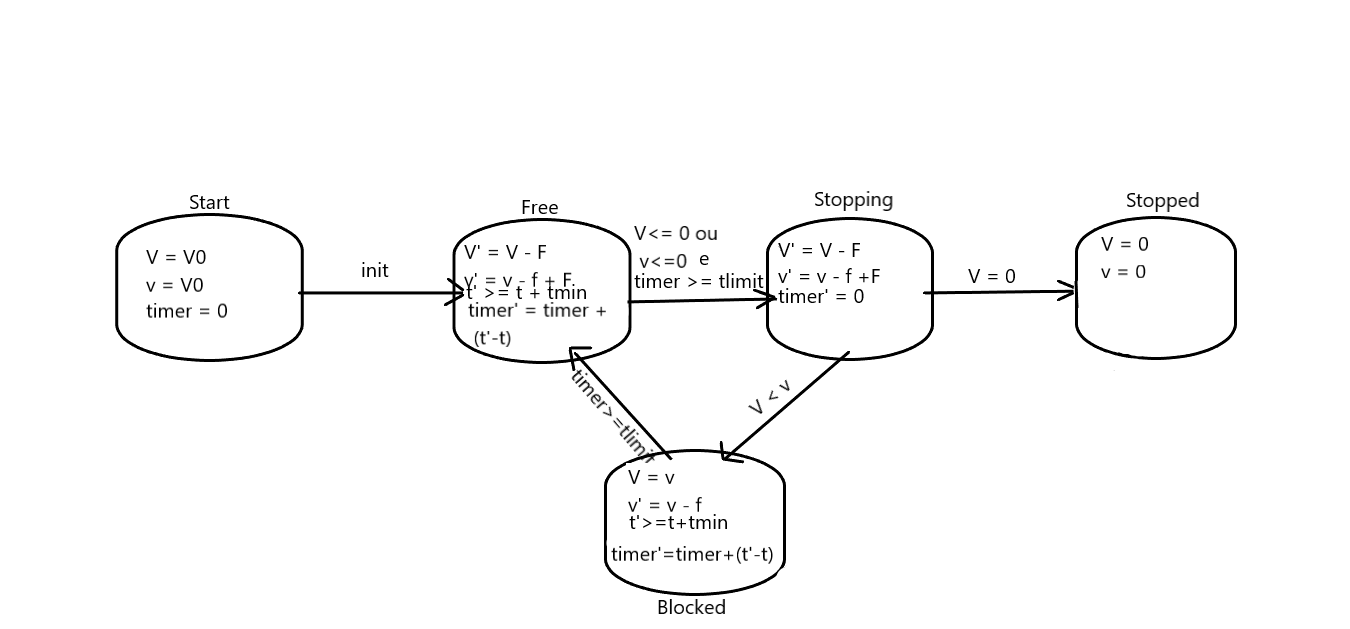

# Condição de segurança

De forma a restringir que não seja possivel que o sistema permaneça no estado FREE ou BLOCKED mais que $\,\tau\,$ segundos, desenvolvemos a seguinte proposição:

$$((m = FREE) \implies (timer \le tlimit \wedge timer \gt 0) \vee (m=BLOCKED) \implies  (timer \le tlimit \wedge timer \gt 0))$$

**tlimit**: Variável input que terá o valor $\,\tau\,$, ou seja o maximo de segundos que possa estar em FREE ou BLOCKED.

**timer**: Variável inicializada a 0 que será apenas incrementada até tlimit nos estados FREE ou BLOCKED.

**m**: Variável que representará o estado onde se encontra o sistema. (Poderá ser START, FREE, STOPPING, BLOCKED ou STOPPED)

# Definir o SFOTS que modela a discretização do autómato híbrido.

Na construção do sfots que modela a discretização do autómato híbrido, nós fizemos uso de:

Dois dicionários:

**c**: Com chave STOPPING que indica o valor de c(constante de proporcionalidade) no estado stopping e a chave OTHER que indica o valor de c nos outros estados.

**a**: Com chave BLOCKED que indica o valor de a(constante de atrito) no estado blocked e a chave OTHER que indica o valor de c nos outros estados.

Três variáveis:

**tmin** : Tempo mínimo que o sistema pode usar.

**tlimit**: Já previamente mencionado, é o valor de $\,\tau\,$.

**erro**: Erro de desvio que pode haver nos cálculos, por exemplo se o resultado de um calculo der menor que este, arrrendondamos para 0.

**P**: Peso do carro

Além destas temos então aquelas associadas aos estados , ou seja , START, FREE, STOPPING , BLOCKED , STOPPED.

E OTHER que é apenas uma variável usada como chave nos dicionários previamente mencionados.

In [1]:
from pysmt.shortcuts import *
from pysmt.typing import *

START = Int(-1)
FREE = Int(0)
STOPPING = Int(1)
BLOCKED = Int(2)
STOPPED = Int(3)
OTHER = Int(-2)


MODE = {-1: "START", 0: "FREE", 1: "STOPPING", 2: "BLOCKED", 3: "STOPPED"}

P = Real(1000)
c = {OTHER: Real(0.7), STOPPING: Real(1.8)}
a = {OTHER: Real(0.01), BLOCKED: Real(0.007)}

tmin = 0.2
tlimit = 1
erro = Real(0.1)

Fizemos então uso de várias funções, assim como os outros trabalhos temos um **declare**, que representa a declaração das variáveis usadas no sfots,entre estas temos:

**m**: Estados do sistema.

**V**: Velocidade do carro.

**v**: Velocidade dos pneus do carro.

**timer**: Já foi previamente mencionada, é a variável que vai ser incrementada até tlimit.

**t**: O tempo total do programa.


In [2]:
def declare(i):
    state = {}
    state['m'] = Symbol('m'+str(i),INT)
    state['V'] = Symbol('V'+str(i),REAL)
    state['v'] = Symbol('v'+str(i),REAL)
    state['timer'] = Symbol('timer'+str(i),REAL)
    state['t'] = Symbol('t'+str(i),REAL)
    return state

A função **init** que trata da inicialização das variáveis do sistema , representada pelo seguinte predicado:

$$m=START \wedge timer = 0 \wedge t = 0 \wedge v = V0 \wedge V = V0$$

(V0 como o próprio enunciado indica é a velocidade input do sistema)

In [3]:
def init(state):
    return And(Equals(state['m'],START),
               Equals(state['timer'],Real(0)),
               Equals(state['t'],Real(0)),
               Equals(state['v'],Real(V0)),
               Equals(state['V'],Real(V0)))

A função trans que representará as transições entre os estados, faz uso dos seguintes predicados:

Transições untimed:

$$m = START \wedge m' = FREE \wedge t' = t \wedge V' = V \wedge v' = v \wedge timer' = 0 \wedge t' = 0$$
$$\vee$$
$$\text{sem erro :=} (m = FREE \wedge m' = STOPPING \wedge t' = t \wedge V > 0.1 \wedge v > 0.1 \wedge V' = V \wedge v' = v \wedge timer \ge tlimit \wedge timer' = 0)$$
$$\vee$$
$$\text{com erro }:= (m = FREE \wedge m' = STOPPING \wedge t' = t \wedge ((V - F \le erro \wedge V - F \gt 0) \vee (v - f + F \le erro \wedge v - f + F \gt 0)) \wedge V' = 0 \wedge v' = 0 \wedge timer \lt tlimit \wedge timer' = 0 )$$
$$\vee$$
$$m = STOPPING \wedge m' = BLOCKED \wedge t' = 0 \wedge V' = V \wedge v' = v \wedge V \le v + erro \wedge V \gt erro \wedge timer' = 0$$
$$\vee$$
$$m = BLOCKED \wedge m' = FREE \wedge t' = t \wedge V' = V \wedge v' = v \wedge timer \ge tlimit \wedge timer' = 0$$
$$\vee$$
$$m = STOPPING \wedge m' = STOPPED \wedge t' = t \wedge ((V - c[STOPPING] * (V - v) \le erro) \vee (v - f + c[STOPPING] * (V - v) \le erro)) \wedge V' = 0 \wedge v' = 0 \wedge timer' = 0 $$

Transições timed:

$$m = FREE \wedge m' = FREE \wedge t' = t + tmin \wedge timer'\lt tlimit \wedge   V' = V - F \wedge v' = v - -f + F \wedge V -F \gt erro \wedge v - f + F \gt erro \wedge V\gt erro \wedge v \gt erro$$

$$\vee$$

$$m = STOPPING \wedge m' = STOPPING \wedge t'= t + tmin \wedge timer' = timer \wedge V'= V - c[STOPPING] * (V-v) \wedge v'= v - f + c[STOPPING] * V - v \wedge V - c[STOPPING] * (V-v) \gt erro \wedge v - f + c[STOPPING] * V - v \gt erro \wedge v \gt erro\wedge V \gt v$$

$$\vee$$

$$m = BLOCKED \wedge m' = BLOCKED \wedge t' \ge t + tmin \wedge timer' =timer +(t'-t) \wedge timer \lt tlimit \wedge V' = v \wedge v' = v - a[blocked] * P)\wedge V \gt erro \wedge v \gt erro$$

$$\vee$$

$$m = STOPPED \wedge m' = STOPPED \wedge timer = timer' \wedge t = t' \wedge V' = 0 \wedge v' = 0$$

In [4]:
def trans(curr,prox):
    f = (a[OTHER] * P)
    F = c[OTHER] * (curr['V'] - curr['v'])
    
#untimed

    start_free = And(Equals(curr['m'],START),Equals(prox['m'],FREE),
                     Equals(prox['t'],curr['t']),
                     Equals(prox['V'],curr['V']),
                     Equals(prox['v'],curr['v']),
                     Equals(prox['timer'],Real(0)),
                     Equals(prox['t'],Real(0)))
    
    free_stopping = Or(And(Equals(curr['m'],FREE),Equals(prox['m'],STOPPING),
                           Equals(prox['t'],curr['t']),
                           GT(curr['V'],erro),GT(curr['v'],erro),
                           Equals(prox['V'],curr['V']),
                           Equals(prox['v'],curr['v']),
                           GE(curr['timer'],Real(tlimit)),
                           Equals(prox['timer'],Real(0)),
                          ),
                       And(Equals(curr['m'],FREE),Equals(prox['m'],STOPPING),
                           Equals(prox['t'],curr['t']),
                           Or(And(LE(curr['V']- F,erro),GT(curr['V']- F,Real(0))),
                              And(LE(curr['v']- f + F,erro),GT(curr['v']- f + F,Real(0)))),
                           Equals(prox['V'],Real(0)),
                           Equals(prox['v'],Real(0)),
                           LT(curr['timer'],Real(tlimit)),
                           Equals(prox['timer'],Real(0)),
                        ))
    
    stopping_stopped = And(Equals(curr['m'],STOPPING),Equals(prox['m'],STOPPED),
                           Equals(prox['t'],curr['t']),
                           Or(LE(curr['V'] - c[STOPPING] * (curr['V'] - curr['v']),erro),
                              LE(curr['v'] - f + c[STOPPING] * (curr['V'] - curr['v']),erro)),
                           Equals(prox['V'],Real(0)),
                           Equals(prox['v'],Real(0)),
                           Equals(prox['timer'],Real(0)))
    
    stopping_blocked = And(Equals(curr['m'],STOPPING),Equals(prox['m'],BLOCKED),
                           Equals(prox['t'],curr['t']),
                           Equals(prox['V'], curr['V']),
                           Equals(prox['v'], curr['v']),
                           LE(curr['V'],curr['v'] + erro),
                           GT(curr['V'],erro),
                           Equals(prox['timer'],Real(0)))
    
    blocked_free = And(Equals(curr['m'],BLOCKED),Equals(prox['m'],FREE),
                       Equals(prox['t'],curr['t']),
                       Equals(prox['V'],curr['V']),
                       Equals(prox['v'],curr['v']),
                       GE(curr['timer'],Real(tlimit)),
                       Equals(prox['timer'],Real(0)))

                           
#timed

    free_free = And(Equals(curr['m'],FREE),Equals(prox['m'],FREE),
                    GE(prox['t'],curr['t'] + Real(tmin)),
                    Equals(prox['timer'],curr['timer'] + (prox['t']-curr['t'])),
                    LT(curr['timer'],Real(tlimit)),
                    Equals(prox['V'],(curr['V'] - F)),
                    Equals(prox['v'],(curr['v'] - f + F)),
                    GT((curr['V'] - F),erro),
                    GT((curr['v'] - f + F),erro),
                    GT(curr['V'],erro),
                    GT(curr['v'],erro))
    
    stopping_stopping = And(Equals(curr['m'],STOPPING),Equals(prox['m'],STOPPING),
                            Equals(prox['t'],curr['t'] + Real(tmin)),
                            Equals(prox['timer'],curr['timer']),
                            Equals(prox['V'], curr['V'] - c[STOPPING] * (curr['V'] - curr['v'])),
                            Equals(prox['v'],(curr['v']- f + c[STOPPING] * (curr['V'] - curr['v']))),
                            GT(curr['V'] - c[STOPPING] * (curr['V'] - curr['v']),erro),
                            GT(curr['v'] - f + c[STOPPING] * (curr['V'] - curr['v']),erro),
                            GT(curr['v'],erro),
                            GE(curr['V'],curr['v']))
    
    blocked_blocked = And(Equals(curr['m'],BLOCKED),Equals(prox['m'],BLOCKED),
                          GE(prox['t'],curr['t'] + Real(tmin)),
                          Equals(prox['timer'],curr['timer'] + (prox['t']-curr['t'])),
                          LT(curr['timer'],Real(tlimit)),
                          Equals(prox['V'],prox['v']),
                          Equals(prox['v'], curr['v'] - a[BLOCKED] * P),
                          GT(prox['V'],erro),
                          GT(curr['v'],erro))
    
    stopped_stopped =  And(Equals(curr['m'],STOPPED),
                           Equals(prox['m'],STOPPED),
                           Equals(curr['timer'],prox['timer']),
                           Equals(curr['t'],prox['t']),
                           Equals(prox['V'],Real(0)),
                           Equals(prox['v'],Real(0)))
    
    
    return Or(start_free,free_stopping,stopping_blocked,blocked_free,stopping_stopped,free_free,stopping_stopping,blocked_blocked,stopped_stopped)

Por fim para a geração do traço usamos a função **gera_traco** que foi usada durante as aulas, esta dá uso da função auxiliar **print_vars** e do dicionário MODE, previamente mencionado.

In [5]:
def print_vars(s, solver):
    for var in s:
        if s[var].get_type() == REAL:
            print(f"  {var} = {float(solver.get_py_value(s[var]))}")
        if var == "m":
            print(f"  {var} = {MODE[solver.get_py_value(s[var])]}")

def gera_traco(declare,init,trans,k):
    # completar
    states = [declare(i) for i in range(k)]
    with Solver() as solver:
        solver.add_assertion(init(states[0]))
        for i in range(k-1):
            solver.add_assertion(trans(states[i], states[i+1]))
        
        if solver.solve():
            for i,s in enumerate(states):
                print(f"> State {i}:")
                print_vars(s, solver)
        else:
            print("> Not feasible.")


# **Exemplos**

In [6]:
V0 = 100

gera_traco(declare,init,trans,27)

> State 0:
  m = START
  V = 100.0
  v = 100.0
  timer = 0.0
  t = 0.0
> State 1:
  m = FREE
  V = 100.0
  v = 100.0
  timer = 0.0
  t = 0.0
> State 2:
  m = FREE
  V = 100.0
  v = 90.0
  timer = 0.2
  t = 0.2
> State 3:
  m = FREE
  V = 93.0
  v = 87.0
  timer = 0.4
  t = 0.4
> State 4:
  m = FREE
  V = 88.8
  v = 81.2
  timer = 0.6000000000000001
  t = 0.6000000000000001
> State 5:
  m = FREE
  V = 83.48
  v = 76.52
  timer = 0.8
  t = 0.8
> State 6:
  m = FREE
  V = 78.608
  v = 71.392
  timer = 1.0
  t = 1.0
> State 7:
  m = STOPPING
  V = 78.608
  v = 71.392
  timer = 0.0
  t = 1.0
> State 8:
  m = STOPPING
  V = 65.61919999999999
  v = 74.3808
  timer = 0.0
  t = 1.2000000000000002
> State 9:
  m = BLOCKED
  V = 65.61919999999999
  v = 74.3808
  timer = 0.0
  t = 1.2000000000000002
> State 10:
  m = BLOCKED
  V = 67.3808
  v = 67.3808
  timer = 0.2
  t = 1.4000000000000001
> State 11:
  m = BLOCKED
  V = 60.3808
  v = 60.3808
  timer = 0.4
  t = 1.6
> State 12:
  m = BLOCKED
  V 

In [7]:
V0 = 70

gera_traco(declare,init,trans,20)

> State 0:
  m = START
  V = 70.0
  v = 70.0
  timer = 0.0
  t = 0.0
> State 1:
  m = FREE
  V = 70.0
  v = 70.0
  timer = 0.0
  t = 0.0
> State 2:
  m = FREE
  V = 70.0
  v = 60.0
  timer = 0.2
  t = 0.2
> State 3:
  m = FREE
  V = 63.0
  v = 57.0
  timer = 0.4
  t = 0.4
> State 4:
  m = FREE
  V = 58.8
  v = 51.2
  timer = 0.6000000000000001
  t = 0.6000000000000001
> State 5:
  m = FREE
  V = 53.48
  v = 46.519999999999996
  timer = 0.8
  t = 0.8
> State 6:
  m = FREE
  V = 48.608
  v = 41.391999999999996
  timer = 1.0
  t = 1.0
> State 7:
  m = STOPPING
  V = 48.608
  v = 41.391999999999996
  timer = 0.0
  t = 1.0
> State 8:
  m = STOPPING
  V = 35.6192
  v = 44.3808
  timer = 0.0
  t = 1.2000000000000002
> State 9:
  m = BLOCKED
  V = 35.6192
  v = 44.3808
  timer = 0.0
  t = 1.2000000000000002
> State 10:
  m = BLOCKED
  V = 37.3808
  v = 37.3808
  timer = 0.2
  t = 1.4000000000000001
> State 11:
  m = BLOCKED
  V = 30.3808
  v = 30.3808
  timer = 0.4
  t = 1.6
> State 12:
  m = 

In [8]:
V0 = 20

gera_traco(declare,init,trans,7)

> State 0:
  m = START
  V = 20.0
  v = 20.0
  timer = 0.0
  t = 0.0
> State 1:
  m = FREE
  V = 20.0
  v = 20.0
  timer = 0.0
  t = 0.0
> State 2:
  m = FREE
  V = 20.0
  v = 10.0
  timer = 0.6
  t = 0.6
> State 3:
  m = FREE
  V = 13.0
  v = 6.999999999999999
  timer = 0.8
  t = 0.8
> State 4:
  m = FREE
  V = 8.8
  v = 1.1999999999999995
  timer = 1.0
  t = 1.0
> State 5:
  m = STOPPING
  V = 8.8
  v = 1.1999999999999995
  timer = 0.0
  t = 1.0
> State 6:
  m = STOPPED
  V = 0.0
  v = 0.0
  timer = 0.0
  t = 1.0


# Verificações sobre o modelo

## **Verificar que as condições de segurança são invariantes do sistema**

Para a prova genérica destas condições serem invariantes do sistema usaremos então a função **kinduction_always**, que terá como parâmetro a função **checkblockedorfree** em que esta será a representação em código das condições de segurança.

In [9]:
def kinduction_always(declare,init,trans,inv,k):
    # completar
    with Solver(name="z3") as solver:
        s = [declare(i) for i in range(k)]
        solver.add_assertion(init(s[0]))
        for i in range(k-1):
            solver.add_assertion(trans(s[i],s[i+1]))
            
        for i in range(k):
            solver.push()
            solver.add_assertion(Not(inv(s[i])))
            if solver.solve():
                print(f"> Contradição! O invariante não se verifica nos k estados iniciais.")
                for st in s:
                    print(f"> State {i}.")
                return
            solver.pop()
        
        s2 = [declare(i+k) for i in range(k+1)]
        
        for i in range(k):
            solver.add_assertion(inv(s2[i]))
            solver.add_assertion(trans(s2[i],s2[i+1]))
        
        solver.add_assertion(Not(inv(s2[-1])))
        
        if solver.solve():
            print(f"> Contradição! O passo indutivo não se verifica.")
            for i,state in enumerate(s):
                print(f"> State {i}.")
            return
        
        print(f"> A propriedade verifica-se por k-indução (k={k}).")

In [10]:
def checkblockedorfree(s):
    t1 =Implies(Equals(s["m"],FREE),And(LE(s["timer"],Real(tlimit)),GT(s["timer"],Real(0))))
    t2 =Implies(Equals(s["m"],BLOCKED),And(LE(s["timer"],Real(tlimit)),GT(s["timer"],Real(0))))
    
    #Implies(And(LE(s["timer"], Real(tlimit)),GT(s["timer"],Real(0))),
    #           Or(Equals(s["m"], FREE),Equals(s["m"],BLOCKED)))
    
    return Or(t1,t2)


Usando então a **kinduction_always** verificamos que as condições de segurança são invariantes do sistema

In [11]:
kinduction_always(declare,init,trans,checkblockedorfree, 5)

> A propriedade verifica-se por k-indução (k=5).


## Verificar que o sistema atinge o estado STOPPED eventualmente

Para a prova que este sistema atinge , eventualmente, o estado STOPPED, usaremos a função **bmc_eventually** que receberá como parâmetro a função **stoppedeventually** que é a representação em código da seguinte proposição:
$$(m == STOPPED)$$

Alteramos ligeiramente a função **bmc_eventually** de forma a adaptarmos para este contexto, tivemos de na variavel **has_loop** incluir nos equals entre states todas as variáveis declaradas no modelo.


In [12]:
def bmc_eventually(declare,init,trans,prop,bound):
    # completar
    with Solver() as solver:
        states = [declare(i) for i in range(bound)]
        solver.add_assertion(init(states[0]))
        
        for k in range(bound):
            if k > 0:
                solver.add_assertion(trans(states[k-1], states[k]))
            
            solver.push()
            has_loop = Or(And(Equals(states[i]['m'], states[k]['m']),Equals(states[i]['V'], states[k]['V']),
                              Equals(states[i]['v'], states[k]['v']),Equals(states[i]['t'], states[k]['t']),
                              Equals(states[i]['timer'], states[k]['timer']))
                          for i in range(k))
            solver.add_assertion(has_loop)

            never_occurs = And(Not(prop(states[i])) for i in range(k+1))
            solver.add_assertion(never_occurs)

            if solver.solve():
                print(f"> Property does not necessarily occur for {k} first states. Counter-example:")
                for i,s in enumerate(states[:k+1]):
                    print(f"> State {i}: ")
                    print_vars(s, solver)
                return
            else:
                if k==bound-1:
                    print(f"> Property holds for execution of length {bound}.")
                else:
                    solver.pop()


In [13]:
def stoppedeventually(s):
    return Equals(s['m'],STOPPED) 

Usando então a **bmc_eventually** adaptada, conseguimos verificar que o estado STOPPED é atingido eventualmente.

In [14]:
bmc_eventually(declare,init,trans,stoppedeventually,30)

> Property holds for execution of length 30.
